In [1]:
# HPC
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Paths and stuff
import os
import sys

import re
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp_init = xr.open_dataset('/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka0005.nc')
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")
vx_uncert_data = surfvel_data_40kms["vx_uncert"].data
vy_uncert_data = surfvel_data_40kms["vy_uncert"].data

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_optim_SVC_3point5_50_new_pickup_2'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
KRMAX = 40
zeta_r = np.arange(0.,1. + 1.0/KRMAX, 1.0/KRMAX)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(6, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1
NTDAMAX = time_ad.shape[0]-1

log_c_slide_init = np.log10(0.85)*np.ones((JMAX+1, IMAX+1))
data = ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp_init['q_geo'].data
log_q_geo = np.where(data > 0, np.log10(data), -10)
log_p_weert = np.log10(3.0)
log_q_weert = np.log10(2.0)
log_enh_fact_da_dummy2d_scalar = np.log10(3.0)
log_enh_intg_da_dummy2d_scalar = np.log10(1.0)
log_n_glen_da_dummy2d_scalar = np.log10(3.0)

# Ensure the sequence in these arrays is the same as defined in ad_specs.h
dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init,
                              "xx_q_geo": log_q_geo,
                              "xx_p_weert": log_p_weert,
                              "xx_q_weert": log_q_weert,
                              "xx_enh_fact_da_dummy2d_scalar": log_enh_fact_da_dummy2d_scalar,
                              "xx_enh_intg_da_dummy2d_scalar": log_enh_intg_da_dummy2d_scalar,
                              "xx_n_glen_da_dummy2d_scalar": log_n_glen_da_dummy2d_scalar}
dict_prior_params_fields_vals = dict_og_params_fields_vals.copy()
dict_params_fields_num_dims = {"xx_c_slide_init": "2D",
                               "xx_q_geo": "2D",
                               "xx_p_weert": "2D",
                               "xx_q_weert": "2D",
                               "xx_enh_fact_da_dummy2d_scalar": "2D",
                               "xx_enh_intg_da_dummy2d_scalar": "2D",
                               "xx_n_glen_da_dummy2d_scalar": "2D"}
dict_params_coords = {"time_ad": time_ad,
                      "zeta_c": exp_sigma_level,
                      "zeta_r": zeta_r,
                      "y": yModel40,
                      "x": xModel40}
dict_params_attrs_type = {"xx_c_slide_init": "nodiff",
                          "xx_q_geo": "nodiff",
                          "xx_p_weert": "nodiff",
                          "xx_q_weert": "nodiff",
                          "xx_enh_fact_da_dummy2d_scalar": "nodiff",
                          "xx_enh_intg_da_dummy2d_scalar": "nodiff",
                          "xx_n_glen_da_dummy2d_scalar": "nodiff"}
dict_params_fields_or_scalars = {"xx_c_slide_init": "field",
                                 "xx_q_geo": "field",
                                 "xx_p_weert": "scalar",
                                 "xx_q_weert": "scalar",
                                 "xx_enh_fact_da_dummy2d_scalar": "scalar",
                                 "xx_enh_intg_da_dummy2d_scalar": "scalar",
                                 "xx_n_glen_da_dummy2d_scalar": "scalar"}

year2sec = 3.1556925445e+07
sec2year = 1/year2sec
dict_masks_observables = {"vx_s_g": (vx_uncert_data*sec2year)**(-2),
                          "vy_s_g": (vy_uncert_data*sec2year)**(-2)}

dict_prior_sigmas = {"xx_c_slide_init": 0.3,
                     "xx_q_geo": 0.3,
                     "xx_p_weert": 0.01,
                     "xx_q_weert": 0.01,
                     "xx_enh_fact_da_dummy2d_scalar": 0.01,
                     "xx_enh_intg_da_dummy2d_scalar": 0.01,
                     "xx_n_glen_da_dummy2d_scalar": 0.01}
dict_prior_gammas = {"xx_c_slide_init": 1.0,
                     "xx_q_geo": 1.0,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0,
                     "xx_n_glen_da_dummy2d_scalar": 0.0}
dict_prior_deltas = {"xx_c_slide_init": 2.0e-4,
                     "xx_q_geo": 2.0e-4,
                     "xx_p_weert": 1.0,
                     "xx_q_weert": 1.0,
                     "xx_enh_fact_da_dummy2d_scalar": 1.0,
                     "xx_enh_intg_da_dummy2d_scalar": 1.0,
                     "xx_n_glen_da_dummy2d_scalar": 1.0}
                     
list_fields_to_ignore = None

MAX_ITERS_SOR = 100
OMEGA_SOR = 1.5

ds_state = xr.open_dataset("/scratch2/shreyas/optim_SVC_3point5_50_new_pickup_2/inexact_gn_hessian_cg/state_GNHessCG_iter_25.nc")
ds_prior_X = xr.open_dataset("/scratch2/shreyas/optim_SVC_3point5_50_new/prior_X.nc")

dict_og_params_fields_vals = {"xx_c_slide_init": ds_state["xx_c_slide_init"].data.copy(),
                              "xx_q_geo": ds_state["xx_q_geo"].data.copy(),
                              "xx_p_weert": ds_state["xx_p_weert"].data[0].copy(),
                              "xx_q_weert": ds_state["xx_q_weert"].data[0].copy(),
                              "xx_enh_fact_da_dummy2d_scalar": ds_state["xx_enh_fact_da_dummy2d_scalar"].data[0].copy(),
                              "xx_enh_intg_da_dummy2d_scalar": ds_state["xx_enh_intg_da_dummy2d_scalar"].data[0].copy(),
                              "xx_n_glen_da_dummy2d_scalar": ds_state["xx_n_glen_da_dummy2d_scalar"].data[0].copy()}

DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims,
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables,
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_2", None, ds_prior_X, "0007.nc")

U_misfit_sa = np.load("/scratch2/shreyas/REVD_3point5_50_new_pickup_2/REVD_single_approx/U_misfit_360.npy")
Lambda_misfit_sa = np.load("/scratch2/shreyas/REVD_3point5_50_new_pickup_2/REVD_single_approx/Lambda_misfit_360.npy")

sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa = DA.forward_uq_propagation(U_misfit_sa, Lambda_misfit_sa)
sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa

(4.6164586093072983e+24, 4.0819635979886905e+23, 0.911578031052656)

In [4]:
ds_mean_samples_prior, ds_std_samples_prior = DA.pointwise_marginals("prior", 5000)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 5000, U_misfit_sa, Lambda_misfit_sa)

In [ ]:
ds_subset_sample_prior_1 = DA.sample_prior()
ds_subset_sample_prior_2 = DA.sample_prior()

ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

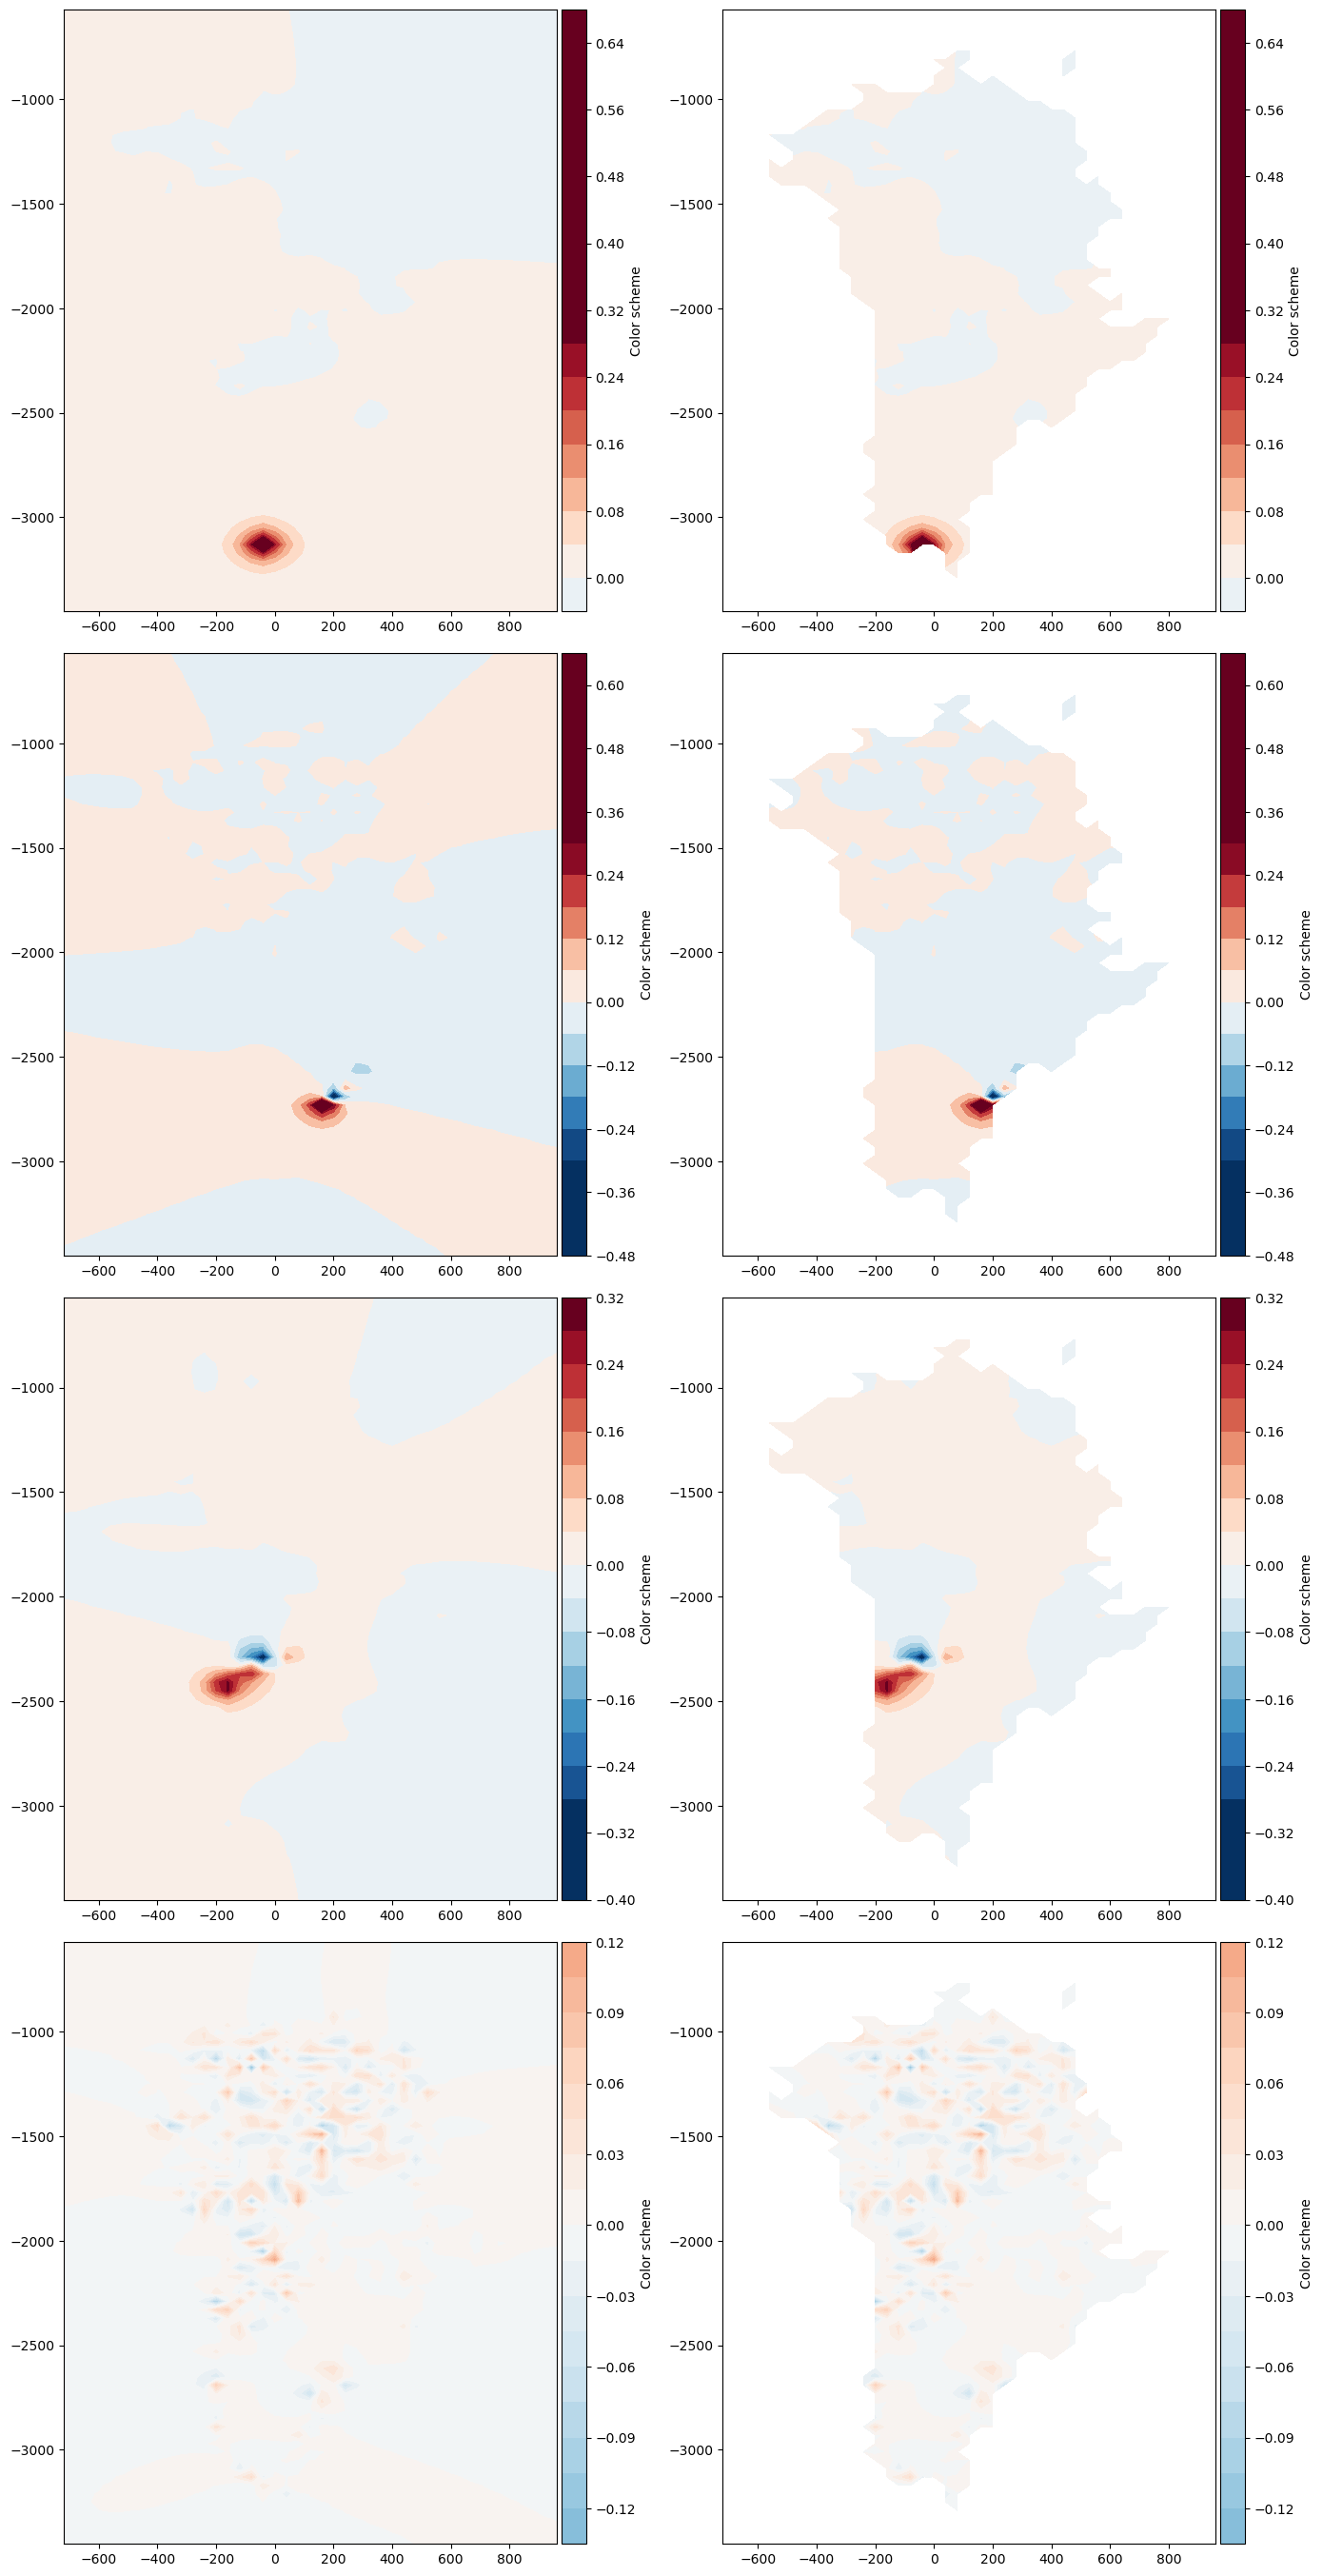

In [5]:
U_misfit_sa_reshaped = np.reshape(U_misfit_sa[:73*43, :], (73, 43, -1))

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

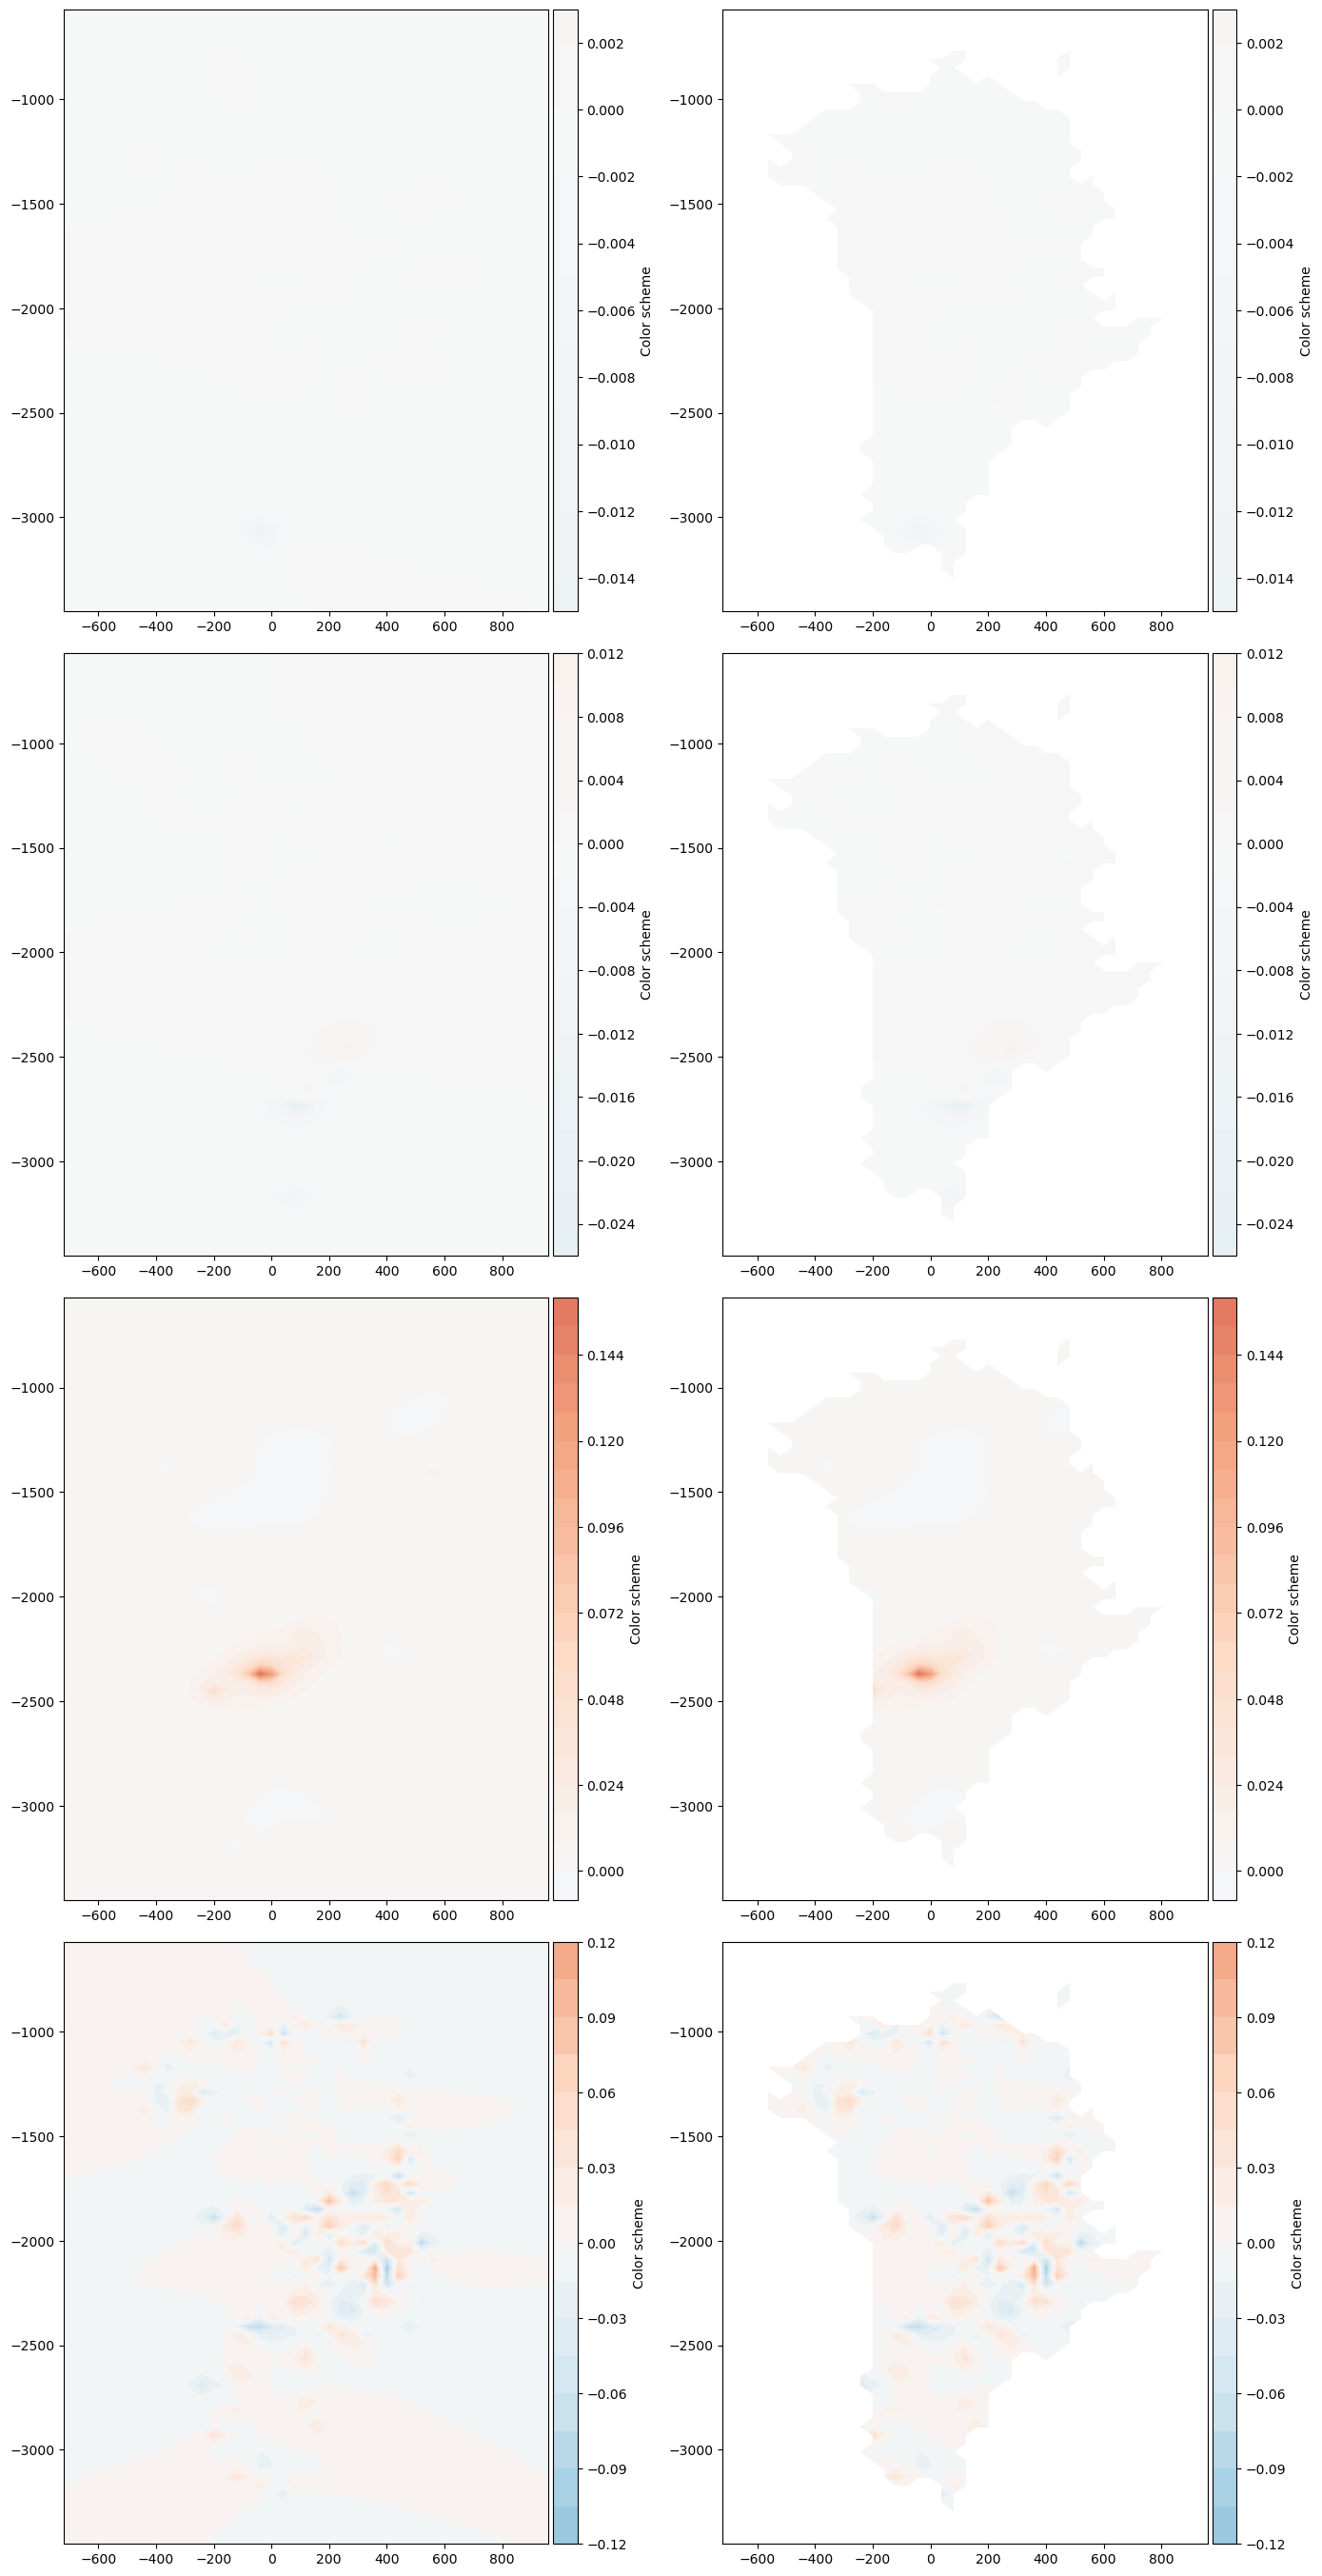

In [6]:
U_misfit_sa_reshaped = np.reshape(U_misfit_sa[73*43:2*73*43, :], (73, 43, -1))

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

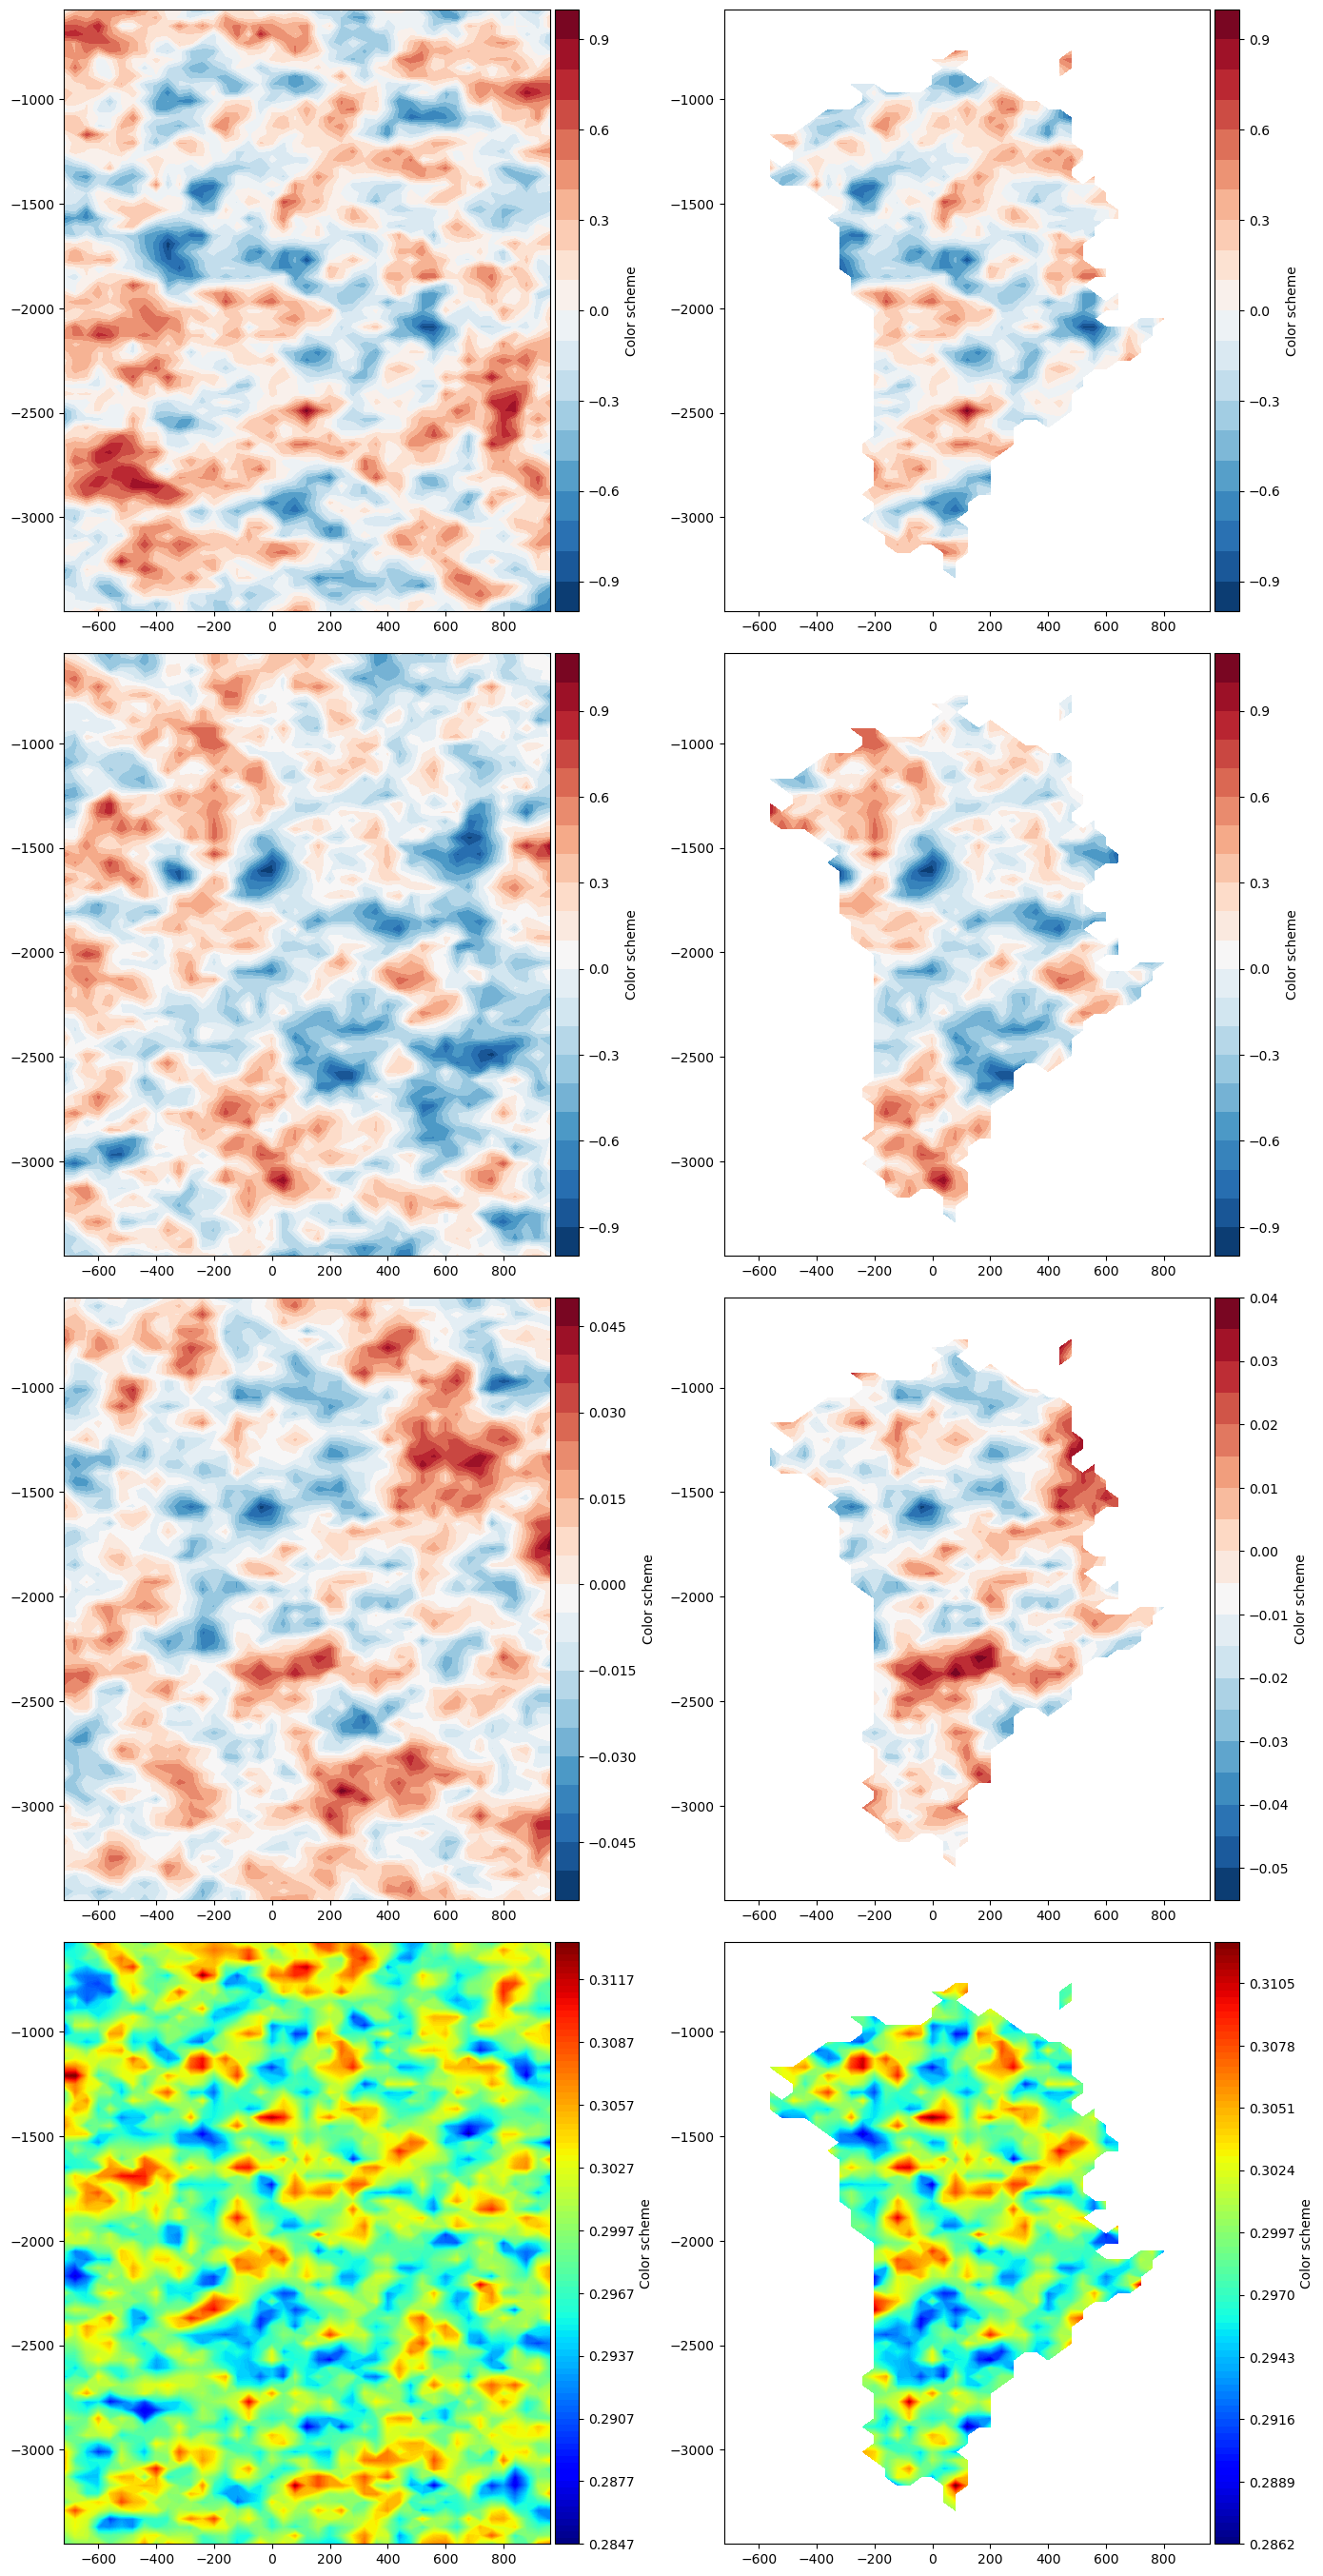

In [7]:
plt.rcParams["figure.figsize"] = (16,24)
n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

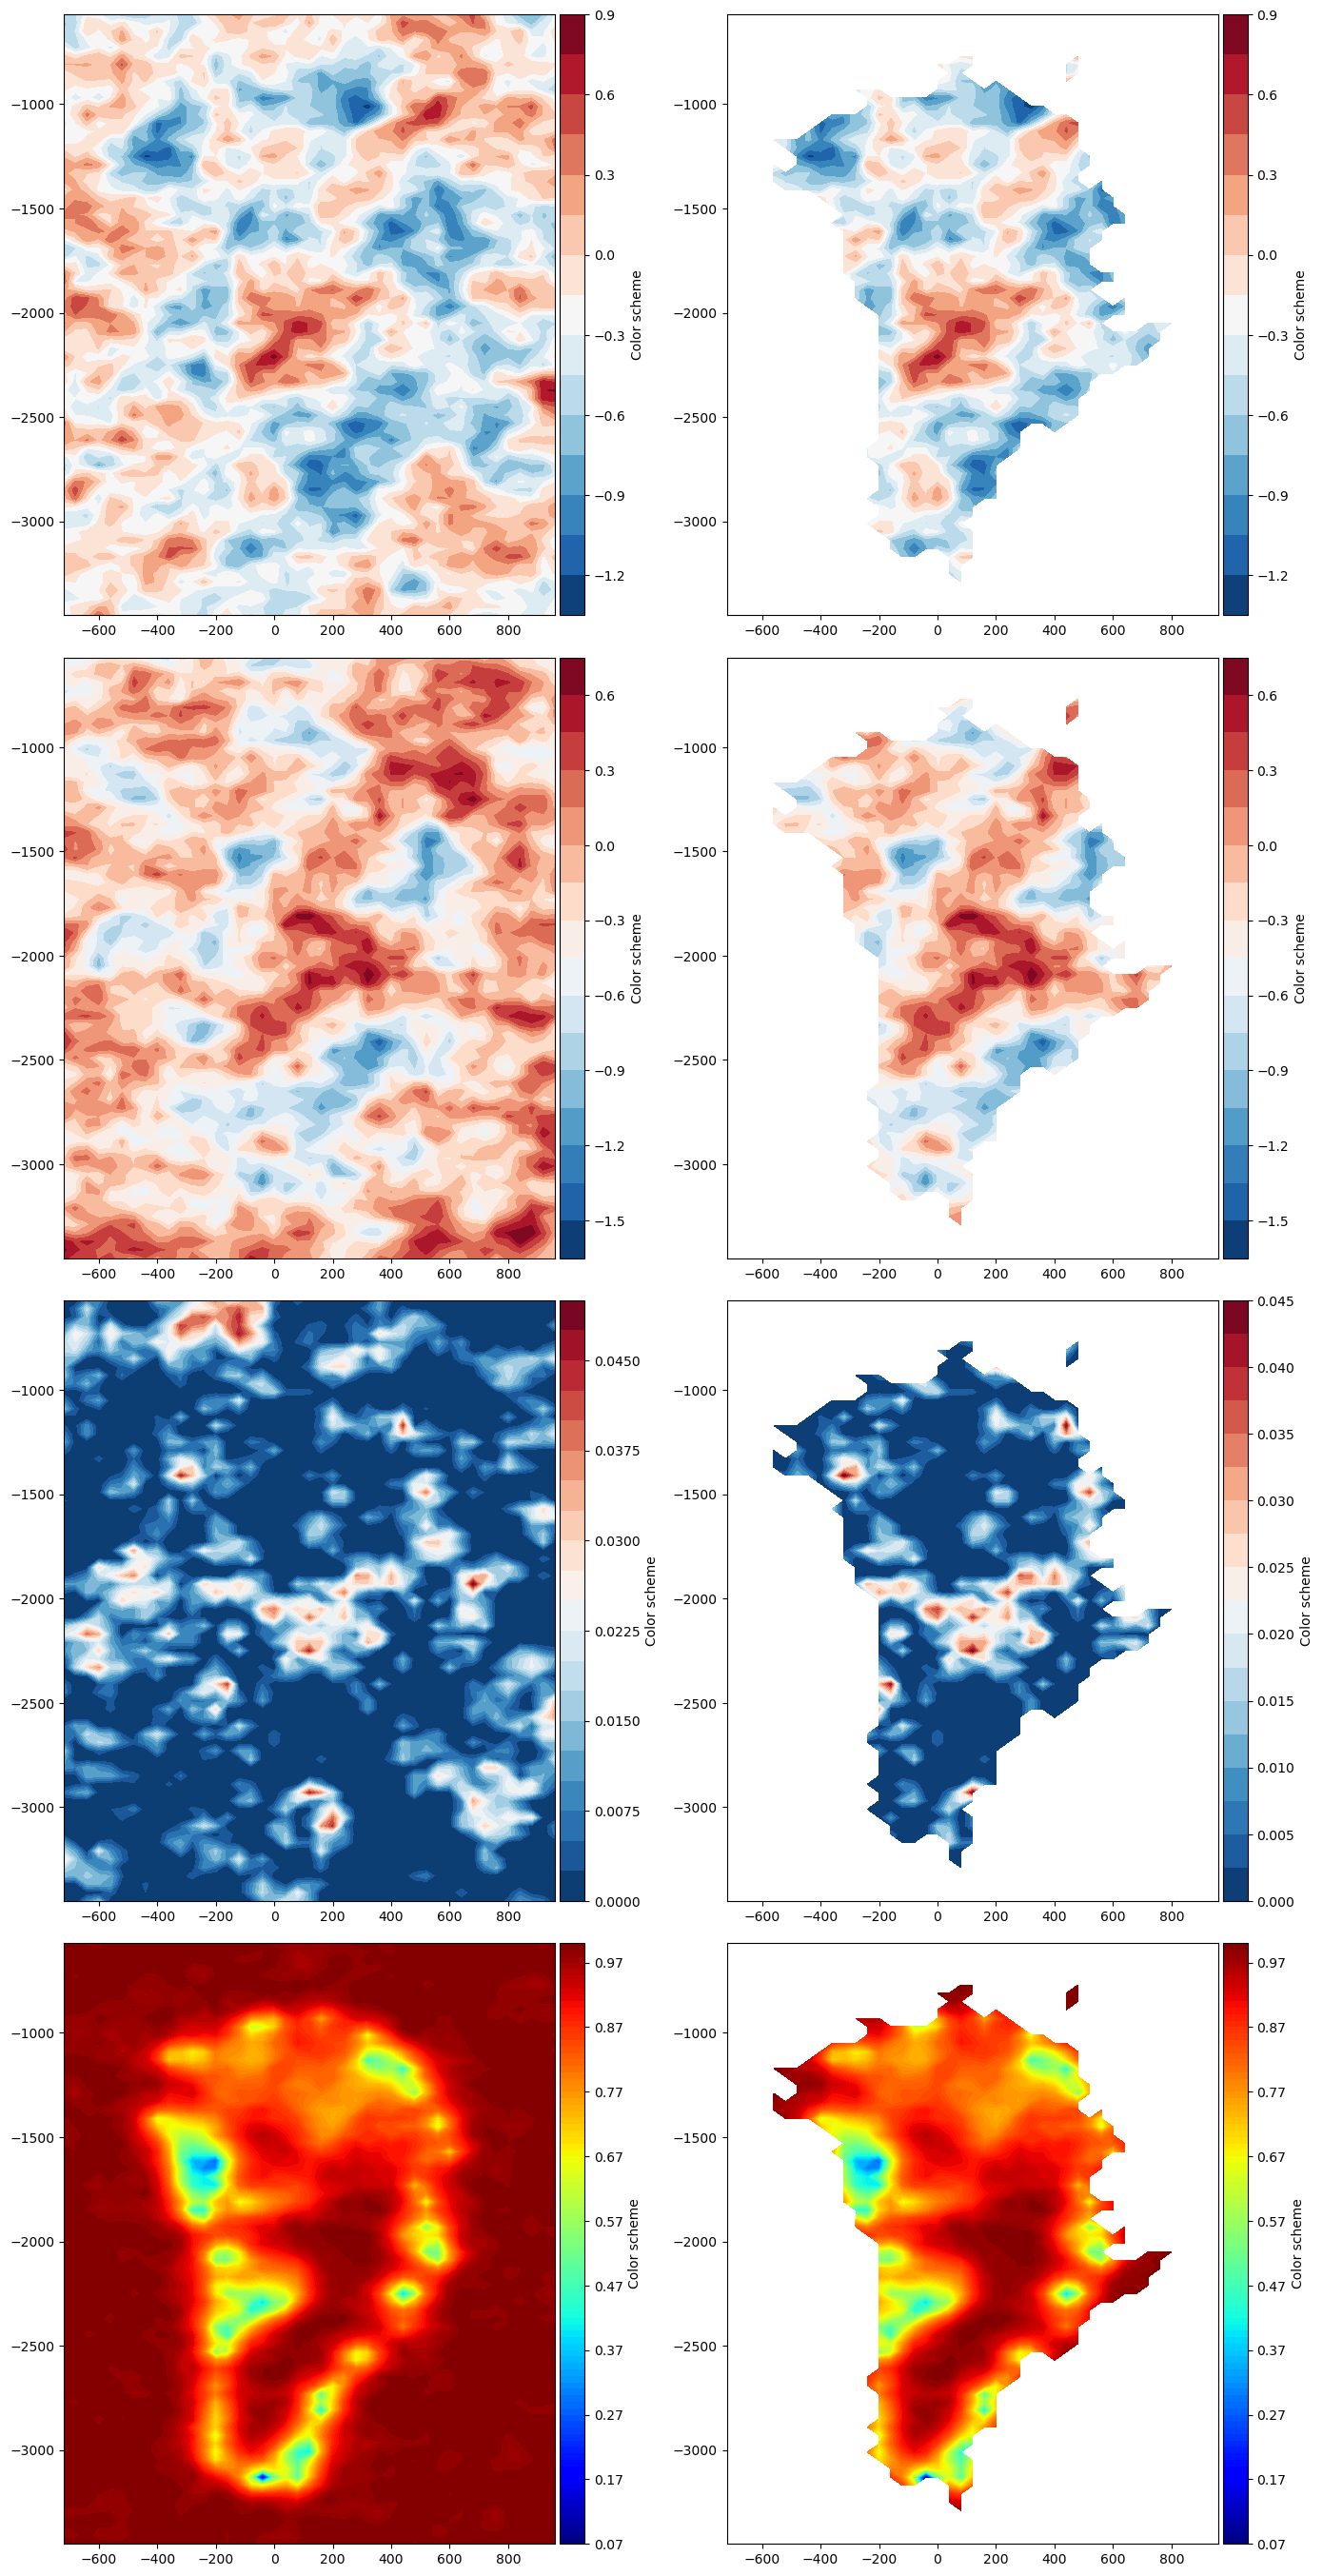

In [8]:
ds = ds_state.copy()

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         np.clip(ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data, 0, 1),
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         np.clip(ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data, 0, 1)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         np.clip(ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data, 0, 1),
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         np.clip(ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data, 0, 1)*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

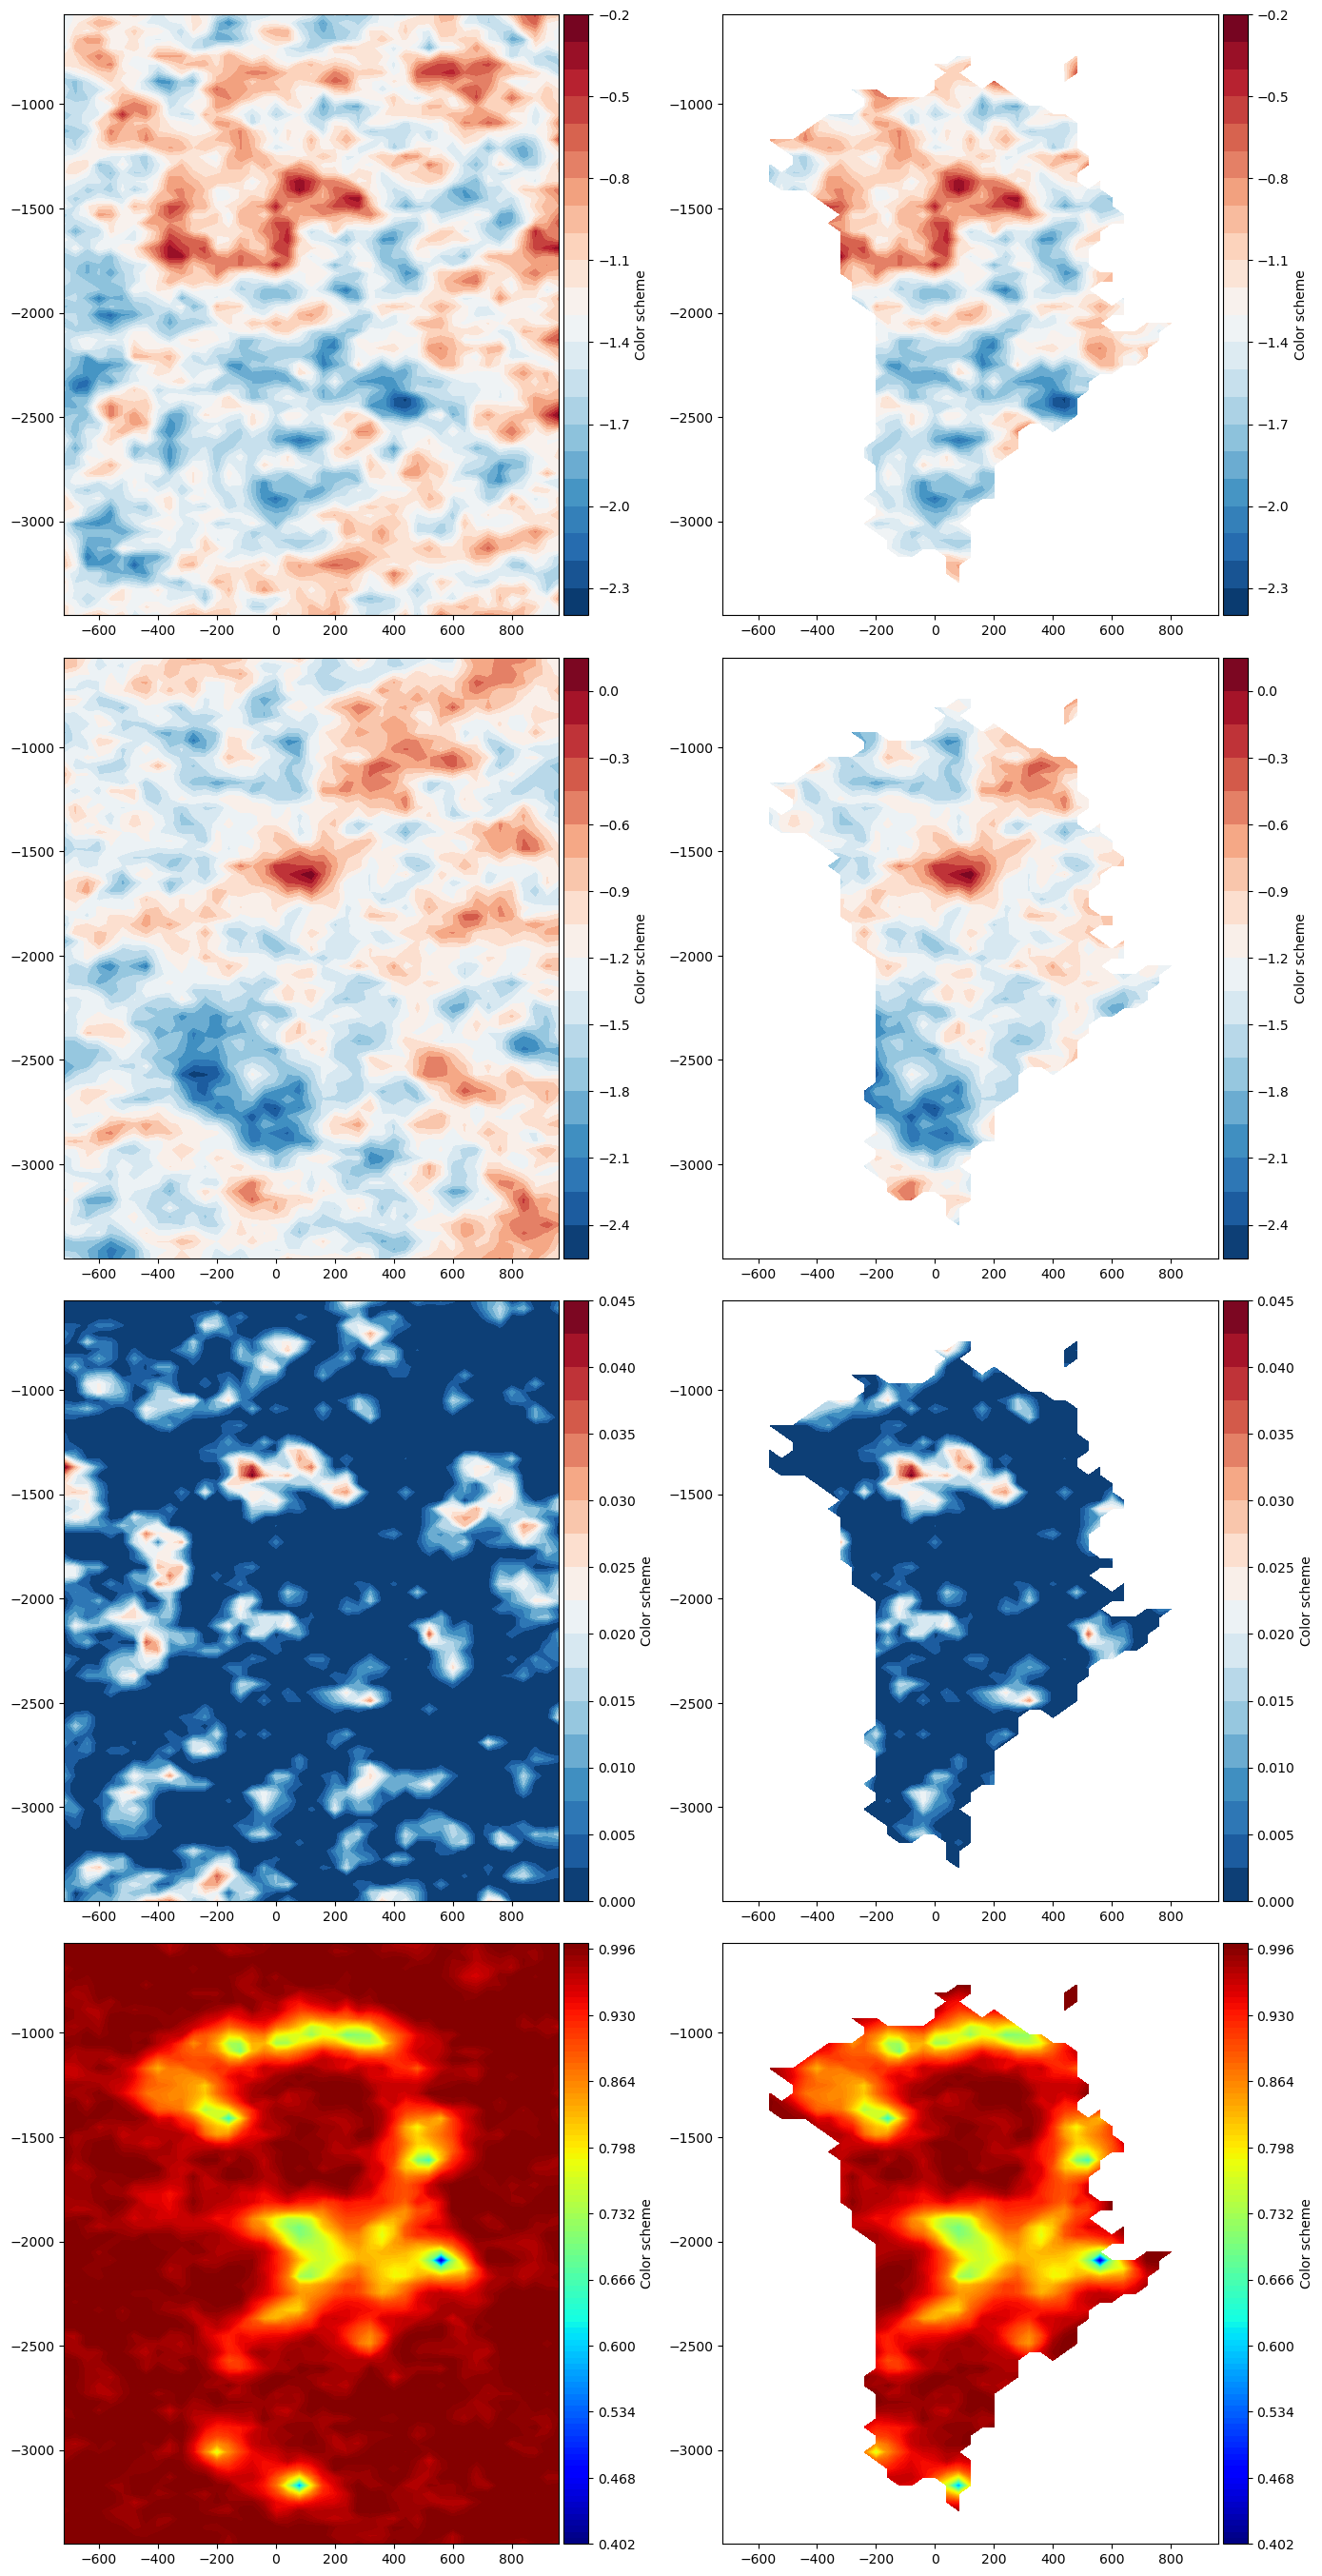

In [9]:
n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_q_geo"].data + ds_subset_sample_posterior_1["xx_q_geod"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_q_geo"].data + ds_subset_sample_posterior_1["xx_q_geod"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_q_geo"].data + ds_subset_sample_posterior_2["xx_q_geod"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_q_geo"].data + ds_subset_sample_posterior_2["xx_q_geod"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         np.clip(ds_mean_samples_posterior["xx_q_geod"].data/ds_std_samples_posterior["xx_q_geod"].data, 0, 1),
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         np.clip(ds_mean_samples_posterior["xx_q_geod"].data/ds_std_samples_posterior["xx_q_geod"].data, 0, 1)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         np.clip(ds_std_samples_posterior["xx_q_geod"].data/ds_std_samples_prior["xx_q_geod"].data, 0, 1),
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         np.clip(ds_std_samples_posterior["xx_q_geod"].data/ds_std_samples_prior["xx_q_geod"].data, 0, 1)*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [10]:
ds_scalars = xr.load_dataset("/scratch2/shreyas/optim_SVC_3point5_50_new_pickup_2/inexact_gn_hessian_cg/state_GNHessCG_iter_29.nc")
10.0**ds_scalars["xx_p_weert"].data[0],\
10.0**ds_scalars["xx_q_weert"].data[0],\
10.0**ds_scalars["xx_enh_fact_da_dummy2d_scalar"].data[0],\
10.0**ds_scalars["xx_enh_intg_da_dummy2d_scalar"].data[0],\
10.0**ds_scalars["xx_n_glen_da_dummy2d_scalar"].data[0]

(3.069158713009014,
 1.911678308820497,
 2.4925770170379247,
 0.9907601350543286,
 3.573157565164902)

In [11]:
ds_scalars["xx_p_weert"].data[0],\
ds_scalars["xx_q_weert"].data[0],\
ds_scalars["xx_enh_fact_da_dummy2d_scalar"].data[0],\
ds_scalars["xx_enh_intg_da_dummy2d_scalar"].data[0],\
ds_scalars["xx_n_glen_da_dummy2d_scalar"].data[0]

(0.48701934734409874,
 0.2814148123865534,
 0.396648586264668,
 -0.004031476323416567,
 0.5530521676641994)

In [12]:
ds_std_samples_posterior["xx_p_weertd"].data, ds_std_samples_prior["xx_p_weertd"].data

(array([0.01004363]), array([0.01016768]))

In [13]:
ds_std_samples_posterior["xx_q_weertd"].data, ds_std_samples_prior["xx_q_weertd"].data

(array([0.00976863]), array([0.01004389]))

In [14]:
ds_std_samples_posterior["xx_enh_fact_da_dummy2d_scalard"].data, ds_std_samples_prior["xx_enh_fact_da_dummy2d_scalard"].data

(array([0.00838784]), array([0.01010762]))

In [15]:
ds_std_samples_posterior["xx_enh_intg_da_dummy2d_scalard"].data, ds_std_samples_prior["xx_enh_intg_da_dummy2d_scalard"].data

(array([0.01018464]), array([0.01003068]))

In [16]:
ds_std_samples_posterior["xx_n_glen_da_dummy2d_scalard"].data, ds_std_samples_prior["xx_n_glen_da_dummy2d_scalard"].data

(array([0.00618746]), array([0.00982864]))